In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d azkihimmawan/chest-xray-masks-and-defect-detection


100% 3.11G/3.12G [00:35<00:00, 152MB/s]
100% 3.12G/3.12G [00:35<00:00, 95.3MB/s]


In [5]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import glob as gb
from tqdm import tqdm
import pandas as pd
from skimage.io import imread

In [11]:
train_dir = '/content/train_images/'
test_dir = '/content/test_images/'

In [32]:
X_train=[]
y_train=[]

for folder in tqdm(os.listdir(train_dir)):
    img=cv2.imread(train_dir+folder+'/images/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    X_train.append(img)

    img=cv2.imread(train_dir+folder+'/masks/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(128,128))
    y_train.append(list(img))

X_train=np.array(X_train)
y_train=np.array(y_train,dtype=np.bool)

100%|██████████| 500/500 [01:21<00:00,  6.14it/s]
<ipython-input-32-731121f8011b>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train=np.array(y_train,dtype=np.bool)


In [33]:
X_test=[]

for folder in tqdm(os.listdir(test_dir)):
    img=cv2.imread(test_dir+folder+'/'+folder+'.png')
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(128,128))
    X_test.append(list(img))

X_test=np.array(X_test)

100%|██████████| 65/65 [00:12<00:00,  5.26it/s]


In [34]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2)

In [35]:
import tensorflow as tf


inputs = tf.keras.layers.Input((128, 128, 3))

conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv1 = tf.keras.layers.Dropout(0.1)(conv1)
conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.Dropout(0.1)(conv2)
conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.Dropout(0.2)(conv3)
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.Dropout(0.2)(conv4)
conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
conv5 = tf.keras.layers.Dropout(0.3)(conv5)
conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

up6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = tf.keras.layers.concatenate([up6, conv4])
conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up6)
conv6 = tf.keras.layers.Dropout(0.2)(conv6)
conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

up7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = tf.keras.layers.concatenate([up7, conv3])
conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
conv7 = tf.keras.layers.Dropout(0.2)(conv7)
conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

up8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = tf.keras.layers.concatenate([up8, conv2])
conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
conv8 = tf.keras.layers.Dropout(0.1)(conv8)
conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

up9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(up9)
conv9 = tf.keras.layers.Dropout(0.1)(conv9)
conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

In [36]:
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop=EarlyStopping(patience=5, monitor='val_loss', mode='min')
checkpoint = ModelCheckpoint("model.h5", save_best_only=True, monitor='val_loss')

In [39]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=8, callbacks=[checkpoint, early_stop])

Epoch 1/30
50/50 [==============================] - 8s 47ms/step - loss: 0.9764 - accuracy: 0.7022 - val_loss: 0.5213 - val_accuracy: 0.7489
Epoch 2/30
50/50 [==============================] - 2s 34ms/step - loss: 0.4285 - accuracy: 0.7507 - val_loss: 0.3665 - val_accuracy: 0.7489
Epoch 3/30
50/50 [==============================] - 2s 33ms/step - loss: 0.3346 - accuracy: 0.8078 - val_loss: 0.2969 - val_accuracy: 0.8758
Epoch 4/30
50/50 [==============================] - 2s 31ms/step - loss: 0.2515 - accuracy: 0.8924 - val_loss: 0.2825 - val_accuracy: 0.8912
Epoch 5/30
50/50 [==============================] - 2s 31ms/step - loss: 0.2398 - accuracy: 0.8971 - val_loss: 0.2645 - val_accuracy: 0.8924
Epoch 6/30
50/50 [==============================] - 2s 33ms/step - loss: 0.2310 - accuracy: 0.9004 - val_loss: 0.2331 - val_accuracy: 0.8979
Epoch 7/30
50/50 [==============================] - 1s 28ms/step - loss: 0.2293 - accuracy: 0.9002 - val_loss: 0.2450 - val_accuracy: 0.8957
Epoch 8/30
50

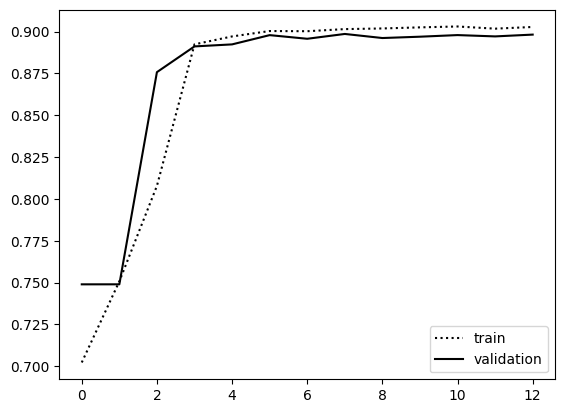

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], linestyle='dotted',color='black', label='train')
plt.plot(history.history['val_accuracy'], linestyle='solid',color='black', label='validation')
plt.legend()
plt.show()

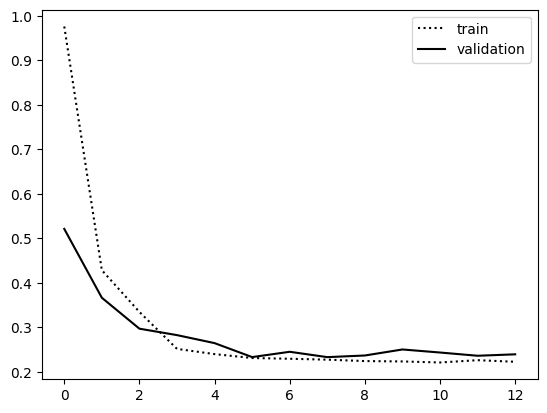

In [41]:
plt.plot(history.history['loss'], linestyle='dotted', color='black', label='train')
plt.plot(history.history['val_loss'], linestyle='solid', color='black', label='validation')
plt.legend()
plt.show()

In [42]:
model = tf.keras.models.load_model('model.h5')

In [44]:
model.evaluate(X_val, y_val)

4/4 [==============================] - 1s 25ms/step - loss: 0.2330 - accuracy: 0.8986


[0.2329750955104828, 0.8986089825630188]

In [45]:
predictions = model.predict(X_val)

4/4 [==============================] - 0s 24ms/step


In [46]:
predictions = (predictions>=0.5).astype(int)

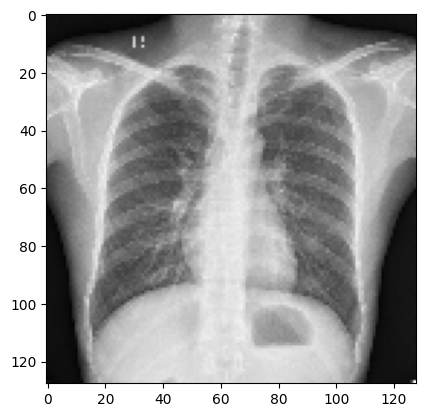

In [49]:
plt.imshow(X_test[25])
plt.show()

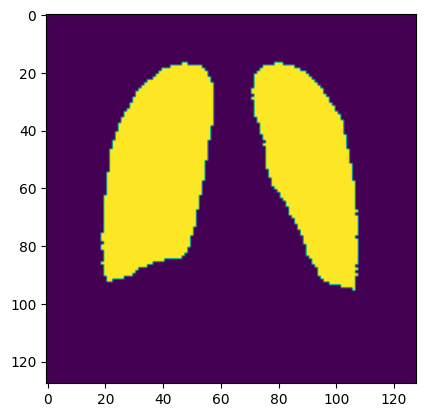

In [50]:
plt.imshow(predictions[10])
plt.show()